<a href="https://colab.research.google.com/github/enerhy/Portfolio/blob/master/CNN_TransferLearn_Callbacks_Filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2021-02-13 11:58:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.217.2.112, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   161MB/s    in 0.4s    

2021-02-13 11:58:38 (161 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
# Set the paths to train/ valid/ and the categories

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [4]:
# Get the number of files in each folder

print(len(os.listdir(train_cats_dir)))
print(len(os.listdir(train_dogs_dir)))
print(len(os.listdir(validation_cats_dir)))
print(len(os.listdir(validation_dogs_dir)))

1000
1000
500
500


In [5]:
# Get the files listed in order to look into them for visualization

fnames_train_dogs = os.listdir(train_dogs_dir)
fnames_train_cats = os.listdir(train_cats_dir)

In [6]:
print(fnames_train_dogs[:10])
print(fnames_train_cats[:10])

['dog.28.jpg', 'dog.275.jpg', 'dog.494.jpg', 'dog.442.jpg', 'dog.708.jpg', 'dog.969.jpg', 'dog.916.jpg', 'dog.51.jpg', 'dog.885.jpg', 'dog.108.jpg']
['cat.997.jpg', 'cat.752.jpg', 'cat.690.jpg', 'cat.347.jpg', 'cat.206.jpg', 'cat.167.jpg', 'cat.205.jpg', 'cat.882.jpg', 'cat.514.jpg', 'cat.242.jpg']


In [7]:
# Preview some images
# Import matplotlib packages
# Creat a grid and a figure

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

nrows = 4
ncols = 4

index = 0


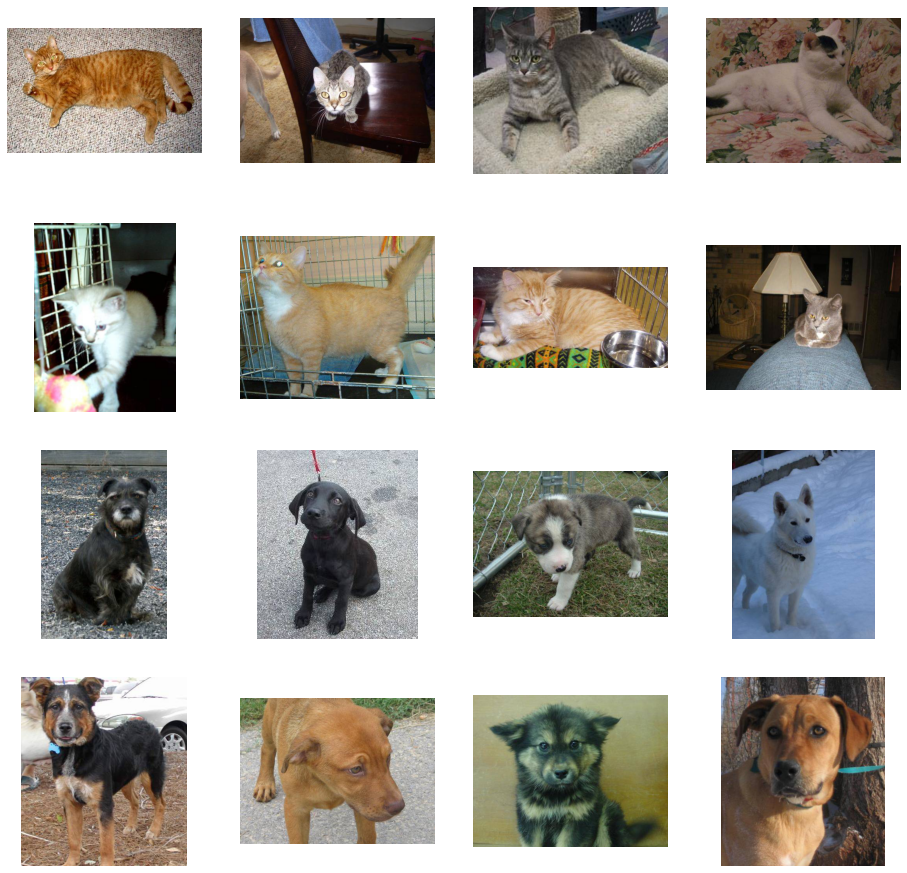

(320, 500, 3)
(374, 500, 3)
(248, 288, 3)
(374, 500, 3)
(500, 374, 3)
(417, 499, 3)
(258, 500, 3)
(374, 500, 3)
(432, 287, 3)
(302, 257, 3)
(375, 499, 3)
(499, 375, 3)
(411, 360, 3)
(375, 499, 3)
(392, 499, 3)
(500, 433, 3)


In [8]:
# Get current figure and create 
fig = plt.gcf()
fig.set_size_inches(4*nrows, 4*ncols)

index +=8

to_display_cats = [os.path.join(train_cats_dir, fname) for fname in fnames_train_cats[index-8:index]
                   ]

to_display_dogs = [os.path.join(train_dogs_dir, fname) for fname in fnames_train_dogs[index-8:index]
                   ]

for i, img_path in enumerate(to_display_cats+to_display_dogs):
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()         


for i, img_path in enumerate(to_display_cats+to_display_dogs):
  img_i = plt.imread(img_path)
  print(img_i.shape)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input
from tensorflow.keras.models import Sequential, Model

# Training Procedure

*   Preprocessing: Instantiate DataGenerator and run flow from directory
*   Instantiatiate a Model (e.g. Class Sequential)
*   Compile the model (optimizer, learning rate, etc)


In [10]:
# Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# At least some kind of normlization to add (rescale =...)
# also some augumentation

train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

# The validation or test datagenerators do not need augumentation
valid_datagen = ImageDataGenerator(rescale=1.0/255.)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150), # for target size, we dont include channels number
                                                    class_mode='binary',
                                                    # Since we use binary_crossentropy loss, we need binary labels
                                                    batch_size=20) # with batch size of 20 and 2000 images we 
                                                    # need 100 step per epoch to go through all images

validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                    target_size=(150, 150), # for target size, we dont include channels number
                                                    class_mode='binary',
                                                    batch_size=20)
                                                    # need 50 step per epoch to go through all images

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# The number of Channels increases down the network.
# We usually have shrinking image and increasing depth

model2 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    # Note: when padding=valid the image is padded at in the first Conv2D layer
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
# Compile the model
from tensorflow.keras.optimizers import Adam, RMSprop
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# The cross entropy is our Loss function to optimize
# It is the oposite of the Log-likeliyhood
# So we eighter minimize crossentropy or optimize log-likeliyhood

## Add Callbacks

### Custom Callback

In [59]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if(logs['val_accuracy']>0.75): # could be only accuracy or some other metric such as "mean_absolute_error"
      print("n\Reached 60% accuracy so cancelling training!")
      self.model.stop_training = True

  # def on_train_batch_end(self, batch, logs=None):
  #       batch_loss = logs['loss']
  #       print("...Training: end of batch {}; got loss : {}".format(batch, batch_loss))

### Predefined callbacks

In [46]:
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger('training.log', append=True, separator=',')

In [ ]:
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"

In [66]:
# Use of other callbacks:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early Stopping when the model doesnt improve with patience
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3, restore_best_weights = True)
# Save the best model

#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# Lets try with training accuracy
# checkpoint_filepath = '/tmp/checkpoint'
filepath="/tmp/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
mc = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True, save_freq='epoch')

In [67]:
# callbacks = [myCallback(), csv_logger, mc]
callbacks = [myCallback(), csv_logger, es, mc]

In [68]:
# Run Training
history = model2.fit(train_generator, 
                              steps_per_epoch=100, # 2000 images = batch_size * steps
                              epochs=10, 
                              verbose=2, 
                              validation_data=validation_generator,
                              validation_steps=50,
                              callbacks=[callbacks]) # 1000 images = batch_size * steps

Epoch 1/10
100/100 - 20s - loss: 0.5302 - accuracy: 0.7385 - val_loss: 0.5203 - val_accuracy: 0.7270

Epoch 00001: val_accuracy improved from -inf to 0.72700, saving model to /tmp/weights-improvement-01-0.73.hdf5
Epoch 2/10
100/100 - 20s - loss: 0.5011 - accuracy: 0.7540 - val_loss: 0.5483 - val_accuracy: 0.7170

Epoch 00002: val_accuracy did not improve from 0.72700
Epoch 3/10
100/100 - 20s - loss: 0.5048 - accuracy: 0.7500 - val_loss: 0.5756 - val_accuracy: 0.7040

Epoch 00003: val_accuracy did not improve from 0.72700
Epoch 4/10
100/100 - 20s - loss: 0.5038 - accuracy: 0.7555 - val_loss: 0.5185 - val_accuracy: 0.7290

Epoch 00004: val_accuracy improved from 0.72700 to 0.72900, saving model to /tmp/weights-improvement-04-0.73.hdf5
Epoch 5/10
100/100 - 20s - loss: 0.5007 - accuracy: 0.7540 - val_loss: 0.5297 - val_accuracy: 0.7430

Epoch 00005: val_accuracy improved from 0.72900 to 0.74300, saving model to /tmp/weights-improvement-05-0.74.hdf5
Epoch 6/10
100/100 - 20s - loss: 0.5027 -

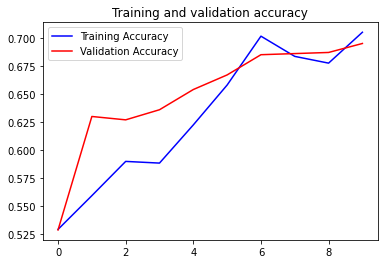

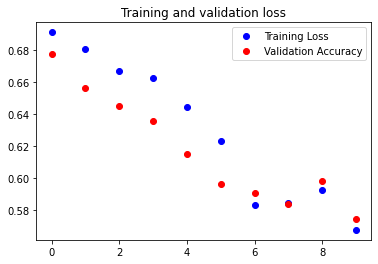

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, 'b', label='Training Accuracy' )
plt.plot  ( epochs, val_acc , 'r', label='Validation Accuracy' )
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss , 'bo', label='Training Loss' )
plt.plot  ( epochs, val_loss , 'ro', label='Validation Accuracy' )
plt.title ('Training and validation loss'   )
plt.legend()

plt.show()

## Manually Save the model

better way is to use checkpoints during training
[Save and Load models - TF](https://www.tensorflow.org/tutorials/keras/save_and_load)

In [ ]:
# !mkdir saved_model
model.save('saved_model')
# The SavedModel format is a directory containing a protobuf binary and a TensorFlow checkpoint.


INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
new_model = tf.keras.models.load_model('saved_model')

In [ ]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
new_model.get_weights()

# Prediction

In [ ]:
# Code to import an image into Colab
from google.colab import files
uploaded=files.upload()


Saving small_labrador.jpeg to small_labrador.jpeg
Saving cat_1.jpg to cat_1.jpg
Saving cat2.jpg to cat2.jpg
Saving German-shepherd.jpg to German-shepherd.jpg


In [ ]:
import numpy as np
# Load the image with keras / and transfer to array
from keras.preprocessing import image 

In [ ]:
# path = '/content/Yellow-Labrador-Retriever.jpg'
# img = image.load_img(path, target_size=(150, 150))
# x=image.img_to_array(img)
# x=np.expand_dims(x, axis=0)
# pred = model.predict(x)
# pred

array([[0.]], dtype=float32)

In [ ]:
for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn

  '''!!! Load the Image with KERAS and a TARGET SIZE '''
  # This is a PIL Image resized - this distors the image proportion
  img=image.load_img(path, target_size=(150, 150))

  ''' Put into an array and expand the dimensions to include the number of images dimension'''
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model2.predict(images, batch_size=10)
  
  print(classes[0])

  if classes[0]>0:
   print(fn + " is a dog")
  
  else:
    print(fn + " is a cat")

[1.]
small_labrador.jpeg is a dog
[1.]
cat_1.jpg is a dog
[1.]
cat2.jpg is a dog
[1.]
German-shepherd.jpg is a dog


# Visualising layers output



*   Creation of model with several outputs - for each layer
*   List item



In [ ]:
model.layers[0].output

<KerasTensor: shape=(None, 148, 148, 16) dtype=float32 (created by layer 'conv2d_3')>

In [ ]:
# Choose layers to be the output
successive_outputs = [layer.output for layer in model.layers]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)


(1, 150, 150, 3)
0.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


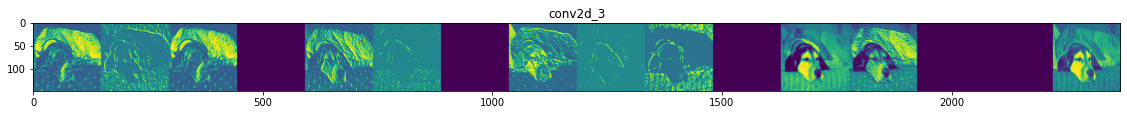

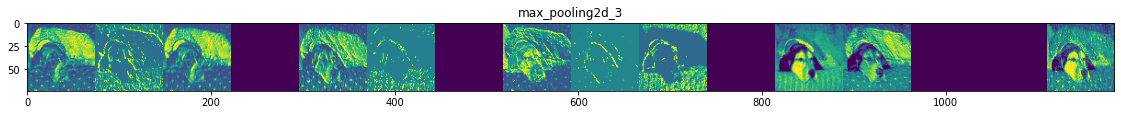

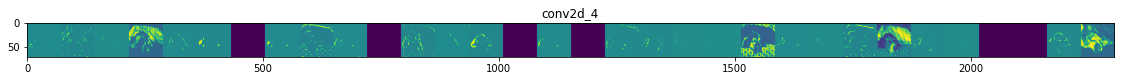

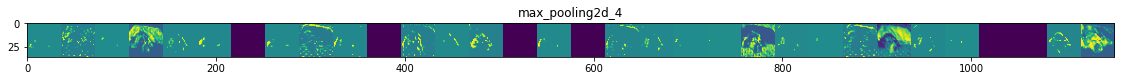

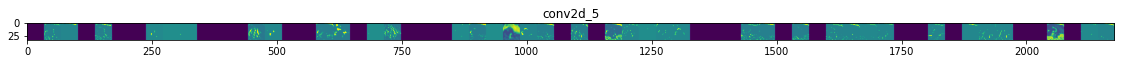

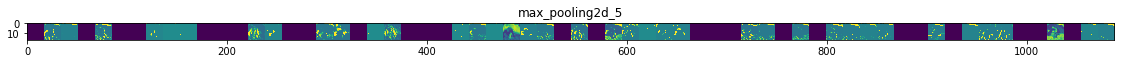

In [ ]:
# Try with a random image
import random
# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in fnames_train_cats]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in fnames_train_dogs]

img_path = random.choice(cat_img_files + dog_img_files)
img = image.load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = image.img_to_array(img)
x   = np.expand_dims(x, axis=0)

# Rescale by 1/255
x /= 255.0
print(x.shape)
print(x.min())
print(x.max())

#--------------

# Getting the output from each layer:
successive_feature_maps = visualization_model.predict(x)
# Get the layers names in the same order:
layer_names = [layer.name for layer in model.layers]

#--------------

# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    # ------- Postprocess the output of the layer - so what comes out after
    # applying convolution with a certain feature map (i) 
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, cmap='viridis' ) 



In [ ]:
print('Number of Layers :', len(successive_feature_maps))
print('Out of the first Conv2D we have :', successive_feature_maps[0].shape)
print('A normalized input - with values [0-1] comes as an array with the following parameters:')
one_output = successive_feature_maps[0][0, :, :, 1]
print('Min: ', one_output.min())
print('Max: ', one_output.max())
print('Mean: ', one_output.mean())

Number of Layers : 9
Out of the first Conv2D we have : (1, 148, 148, 16)
A normalized input - with values [0-1] comes as an array with the following parameters:
Min:  106.27339
Max:  1032.5482
Mean:  128.00002


# Use Pretrained Model - Transfer Learning

In [ ]:
# Download pretraine weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Create an inctance of Inception cutting out the top
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                               include_top=False,
                                               weights = None) # Loading custom weights; weights such as from Imagenet are included


--2021-02-12 20:26:28--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 172.217.164.144, 142.250.73.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   234MB/s    in 0.4s    

2021-02-12 20:26:28 (234 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# load custom weights
pre_trained_model.load_weights(local_weights_file)

# Freeze all layers
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

In [ ]:
# # This two give the layer:

print(pre_trained_model.layers[-1])
print(pre_trained_model.get_layer('mixed10'))
print()
print(pre_trained_model.layers[-1].name)
print(pre_trained_model.layers[-1].output)


mixed10
KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3, 2048), dtype=tf.float32, name=None), name='mixed10/concat:0', description="created by layer 'mixed10'")


In [ ]:
# Choosing the last layer of the network 
last_layer = pre_trained_model.get_layer('mixed7')
# and get the output to continue with - to attach the head of the network
last_output = last_layer.output

In [ ]:
# Putting a head

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

<KerasTensor: shape=(None, 3, 3, 2048) dtype=float32 (created by layer 'mixed10')>

In [ ]:
# Run Training
history = model.fit(train_generator, 
                              steps_per_epoch=100, # 2000 images = batch_size * steps
                              epochs=10, 
                              verbose=2, 
                              validation_data=validation_generator,
                              validation_steps=50) # 1000 images = batch_size * steps

Epoch 1/10
100/100 - 20s - loss: 0.6664 - accuracy: 0.6000 - val_loss: 0.6674 - val_accuracy: 0.5660
Epoch 2/10
100/100 - 20s - loss: 0.6455 - accuracy: 0.6280 - val_loss: 0.6404 - val_accuracy: 0.6320
Epoch 3/10
100/100 - 20s - loss: 0.6404 - accuracy: 0.6330 - val_loss: 0.6381 - val_accuracy: 0.6430
Epoch 4/10
100/100 - 20s - loss: 0.6098 - accuracy: 0.6720 - val_loss: 0.6178 - val_accuracy: 0.6810
Epoch 5/10
100/100 - 20s - loss: 0.6322 - accuracy: 0.6280 - val_loss: 0.6943 - val_accuracy: 0.5460
Epoch 6/10
100/100 - 20s - loss: 0.6077 - accuracy: 0.6675 - val_loss: 0.5993 - val_accuracy: 0.6910
Epoch 7/10
100/100 - 20s - loss: 0.5984 - accuracy: 0.6610 - val_loss: 0.5786 - val_accuracy: 0.6930
Epoch 8/10
100/100 - 20s - loss: 0.5913 - accuracy: 0.6890 - val_loss: 0.6282 - val_accuracy: 0.6680
Epoch 9/10
100/100 - 20s - loss: 0.5838 - accuracy: 0.6865 - val_loss: 0.6094 - val_accuracy: 0.6470
Epoch 10/10
100/100 - 20s - loss: 0.5624 - accuracy: 0.7105 - val_loss: 0.5966 - val_accura

## Pretrained with partially further training

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50 as ResNet50, preprocess_input

In [ ]:
IMAGE_SIZE = [150, 150, 3]

In [ ]:
resnet = ResNet50(
    input_shape=IMAGE_SIZE,
    weights='imagenet',
    include_top=False
)

resnet.summary()

In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# unfreeze pretrained model weights
resnet.trainable = True

# Define first from where the training to start
first_trainable_layer_name = 'conv4_block1_1_conv'

# Freeze all previous layers
for layer in resnet.layers:
  if layer.name == first_trainable_layer_name:
    break

  layer.trainable = False

# Check for if successful       
print('First trainable layer is :', layer.name)

In [ ]:
# Putting a head on the Resnet 
from tensorflow.keras.layers import Dropout, BatchNormalization

x = Flatten()(resnet.output)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model_RN = Model(inputs = resnet.input, outputs=x)

# Compile:
model_RN.compile(optimizer = RMSprop(lr=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# model_RN.summary()

In [ ]:
# Run Training
history = model_RN.fit(train_generator, 
                              steps_per_epoch=100, # 2000 images = batch_size * steps
                              epochs=10, 
                              verbose=2, 
                              validation_data=validation_generator,
                              validation_steps=50) # 1000 images = batch_size * steps